In [2]:
%matplotlib inline

# imports
import os
import pickle
import math
import pyreadr
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy as sp

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## READ IN DATA

In [3]:
dirs = ['TextBlobOutput', 'NaturalLanguageOutput', 'VaderOutput']
output = {}
for d in dirs:
    output[d] = {}
    for f in os.listdir(d):
        if f.endswith('pkl'):
            output[d][f[:-4]] = pd.DataFrame(pd.read_pickle(d+os.sep+f))

## ANALYZE DATA

*NLTK OUTPUT*

In [6]:
candidates = []
positive = []
negative = []
for candidate in output['NaturalLanguageOutput'].keys():
    df_cand = output['NaturalLanguageOutput'][candidate]
    num_pos = len(df_cand[df_cand[0]=='pos'].index)
    num_neg = len(df_cand[df_cand[0]=='neg'].index)
    # add to lists
    candidates.append(candidate)
    positive.append(num_pos)
    negative.append(num_neg)
pos_neg_ratio = [positive[i]/negative[i] for i in range(len(positive))]
df_nltk = pd.DataFrame({'candidate':candidates, \
                        'pos':positive, \
                        'neg':negative, \
                        'pos_neg_ratio':pos_neg_ratio})
df_nltk = df_nltk.sort_values(by='pos_neg_ratio', ascending=True)
display(df_nltk)

,candidate,pos,neg,pos_neg_ratio
4,GovBillWeldSentiment,8404,5306,1.583867
5,WalshFreedomSentiment,8926,5565,1.603953
9,JoinRockySentiment,9619,5576,1.725072
1,BirdieSandersSentiment,36543,21035,1.737247
8,JoeBidenSentiment,6079,3419,1.778005
2,AndrewYangSentiment,6442,3606,1.786467
0,TulsiGabbardSentiment,6532,3586,1.821528
3,ewarrenSentiment,4747,2572,1.845645
11,KamalaHarrisSentiment,5492,2914,1.884695
7,amyklobucharSentiment,6557,3475,1.886906


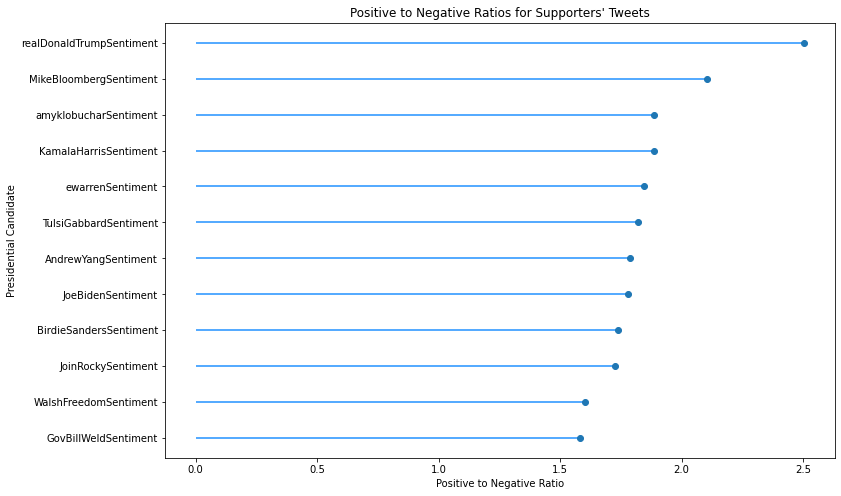

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
data_range = range(1, len(df_nltk.index)+1)
plt.hlines(y=data_range, xmin=0, xmax=df_nltk['pos_neg_ratio'], color='dodgerblue')
plt.plot(df_nltk['pos_neg_ratio'], data_range, "o")
plt.yticks(data_range, df_nltk['candidate'])
plt.title('Positive to Negative Ratios for Supporters\' Tweets')
plt.xlabel('Positive to Negative Ratio')
plt.ylabel('Presidential Candidate')
plt.show()

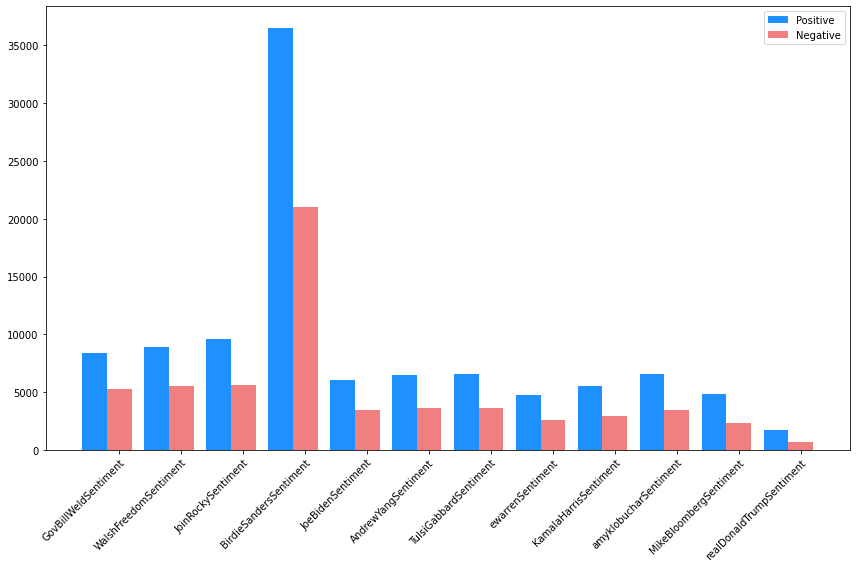

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
index = np.arange(len(df_nltk.index))
bar_width = 0.4
ax.bar(index, df_nltk['pos'], width=bar_width, label='Positive', color='dodgerblue')
ax.bar(index+bar_width, df_nltk['neg'], width=bar_width, label='Negative', color='lightcoral')
plt.xticks(index + bar_width, df_nltk['candidate'], rotation=45, ha="right", rotation_mode="anchor")
plt.legend()
plt.tight_layout()
plt.show()

*VADER OUTPUT*

In [26]:
candidates = []
positive = []
negative = []
mean_score = []
std_score = []

for candidate in output['VaderOutput'].keys():
    df_cand = output['VaderOutput'][candidate]
    # fix bug
    df_cand[0] = ['neg' if i < -0.05 else 'pos' if i > 0.05 else 'neutral' for i in df_cand[1].tolist()]
    num_pos = len(df_cand[df_cand[0]=='pos'].index)
    num_neg = len(df_cand[df_cand[0]=='neg'].index)
    mean = np.mean(df_cand[1])
    std = np.std(df_cand[1])
    # add to lists
    candidates.append(candidate)
    positive.append(num_pos)
    negative.append(num_neg)
    mean_score.append(mean)
    std_score.append(std)
pos_neg_ratio = [positive[i]/negative[i] for i in range(len(positive))]
df_vader = pd.DataFrame({'candidate':candidates, \
                         'pos':positive, \
                         'neg':negative, \
                         'pos_neg_ratio':pos_neg_ratio, \
                         'mean':mean_score, \
                         'std':std_score})
display(df_vader)

,candidate,pos,neg,pos_neg_ratio,mean,std
3,ewarrenSentiment,2968,1493,1.987944,0.128562,0.438809
11,KamalaHarrisSentiment,3432,1755,1.955556,0.126816,0.443281
2,AndrewYangSentiment,4054,2049,1.978526,0.125159,0.436607
7,amyklobucharSentiment,4012,2027,1.979280,0.124242,0.444221
8,JoeBidenSentiment,3710,1970,1.883249,0.118532,0.431587
10,realDonaldTrumpSentiment,794,301,2.637874,0.117567,0.371142
1,BirdieSandersSentiment,21379,10822,1.975513,0.114296,0.420770
9,JoinRockySentiment,5414,2988,1.811914,0.102563,0.411780
4,GovBillWeldSentiment,5219,3053,1.709466,0.095771,0.426741
0,TulsiGabbardSentiment,3652,2131,1.713749,0.094795,0.427571


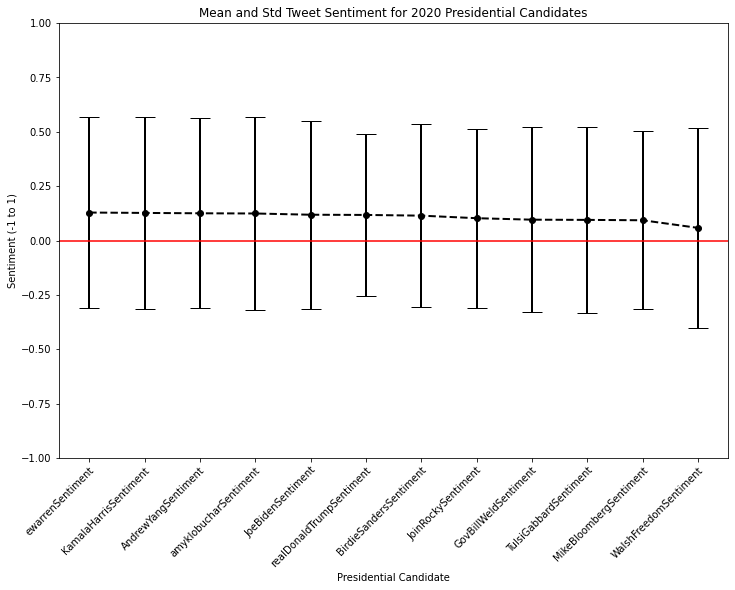

In [56]:
df_vader = df_vader.sort_values(by='mean', ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
plt.errorbar(x=df_vader['candidate'], y=df_vader['mean'], \
             yerr=df_vader['std'], fmt='--ok', lw=2, capsize=10)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
ax.axhline(0, color='r')
plt.ylim([-1, 1])
plt.title('Mean and Std Tweet Sentiment for 2020 Presidential Candidates')
plt.xlabel('Presidential Candidate')
plt.ylabel('Sentiment (-1 to 1)')
plt.show()

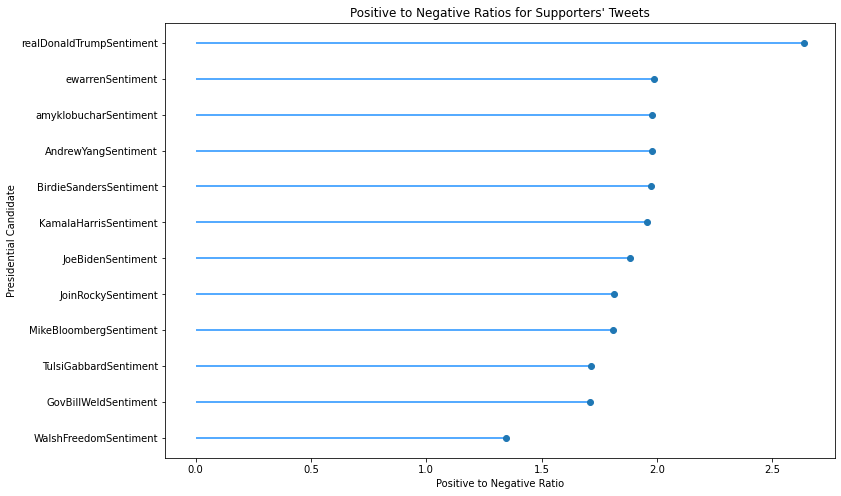

In [57]:
df_vader = df_vader.sort_values(by='pos_neg_ratio', ascending=True)

fig, ax = plt.subplots(figsize=(12,8))
data_range = range(1, len(df_vader.index)+1)
plt.hlines(y=data_range, xmin=0, xmax=df_vader['pos_neg_ratio'], color='dodgerblue')
plt.plot(df_vader['pos_neg_ratio'], data_range, "o")
plt.yticks(data_range, df_vader['candidate'])
plt.title('Positive to Negative Ratios for Supporters\' Tweets')
plt.xlabel('Positive to Negative Ratio')
plt.ylabel('Presidential Candidate')
plt.show()